# Learning PyMC3

## A quick start

In [102]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

### Step 1: Prepare the data

In [236]:
# create some data as a Numpy array or pandas df
data = np.random.randn(40000)
#y = pm.Minibatch(data, batch_size=500)
y = theano.shared(data)
y.get_value()

array([ 0.55469712, -0.7465825 ,  1.23822935, ..., -1.53644622,
       -0.03574599, -1.33451308])

### Step 2: Build the model

In [237]:
# specify a model using the pymc3 Model class
with pm.Model() as model:
    
    # place priors on unknown model parameters
    mu = pm.Normal('mu', mu = 0, sd = 1)
    sd = pm.HalfNormal('sd', sd = 1)
    
    # the likelihood of observations
    # data can be passed in as ndarray or pandas df
    obs = pm.Normal('obs', mu = mu, sd = sd, observed = y)

### Step 3: Sample from the posterior

In [238]:
# sample from the posterior
with model:       
    # draw 2000 samples, run 4 chains in parallel (total 8000 samples)
    step = pm.NUTS(target_accept = 0.99) # increase step size from default 0.8 to 0.99
    posterior = pm.sample(draws = 1000, tune = 500, njobs = 4, step = step) 

100%|██████████| 1500/1500 [00:22<00:00, 65.84it/s]


### Step 4: Diagnose convergence of the MCMC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafe334af98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb1323c94e0>]], dtype=object)

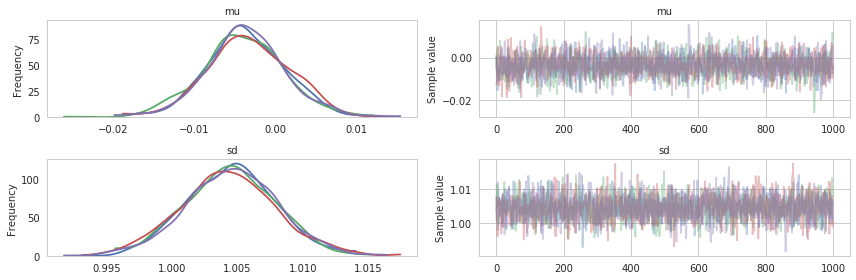

In [239]:
# a traceplot is the most common plot used to analyze sampling results
pm.traceplot(posterior)

In [240]:
# also look at the Gelman-Rubin statistic
pm.gelman_rubin(posterior)

{'mu': 1.0021076248631402, 'sd': 0.99993634888957161}

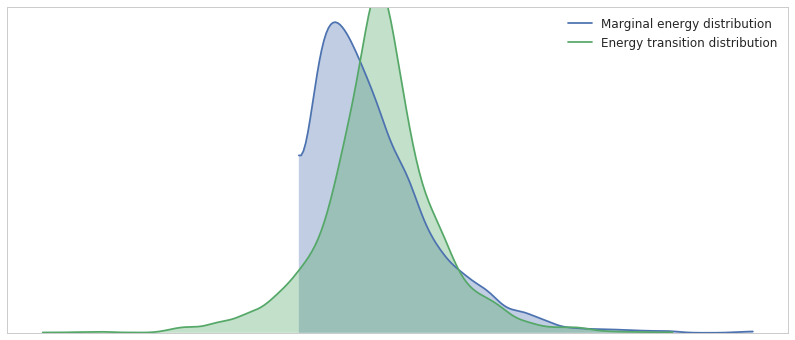

In [241]:
# look at energy plots to assess problems of convergence
pm.energyplot(posterior)

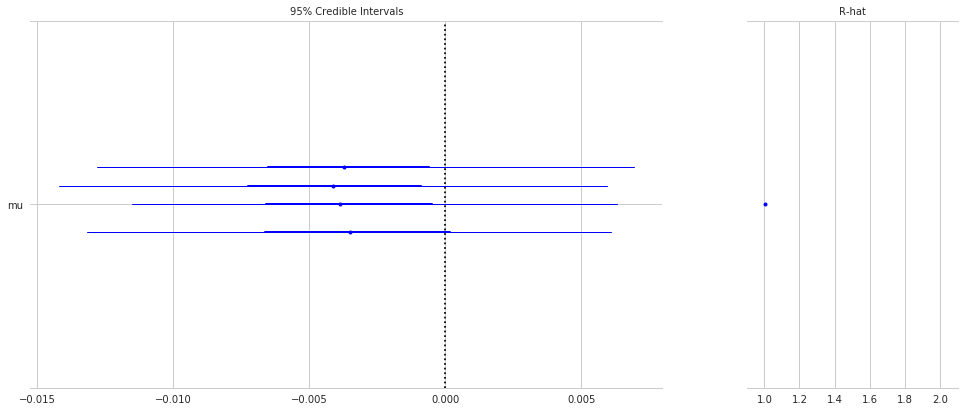

In [243]:
# also look at the forestplot for Rhat values
pm.forestplot(posterior, varnames = ["mu"])

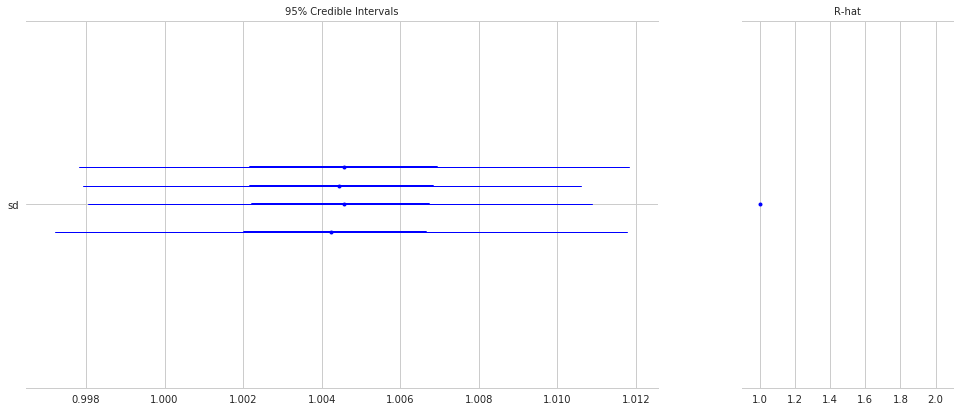

In [244]:
pm.forestplot(posterior, varnames = ["sd"])

### Step 5: Critize the model

In [245]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,-0.003647,0.004930,0.000109,-0.013500,0.006010,1996.0,1.002108
sd,1.004448,0.003452,0.000066,0.997606,1.011261,2479.0,0.999936


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13246ada0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fb132f79fd0>], dtype=object)

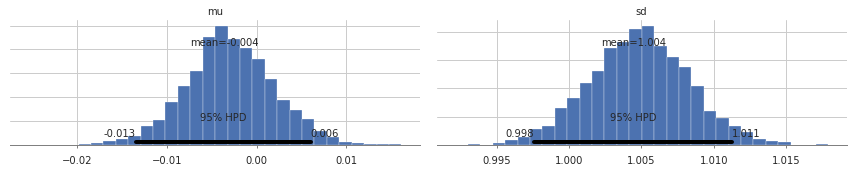

In [246]:
pm.plot_posterior(posterior)

In [247]:
posterior['mu'].shape

(4000,)

In [248]:
len(posterior)

1000

In [249]:
posterior.nchains

4

In [250]:
posterior.get_values('mu', chains = 1).shape # get values of a single chain

(1000,)

### Step 6: Use the model for prediction

In [251]:
new_y = np.random.randn(10)
y.set_value(new_y)

# use pm.sample_ppc to do posterior predictive checks
with model:
    post_pred = pm.sample_ppc(posterior, samples = 1000, size = len(new_y))

100%|██████████| 1000/1000 [00:00<00:00, 1918.79it/s]


In [252]:
post_pred['obs'].shape

(1000, 10)

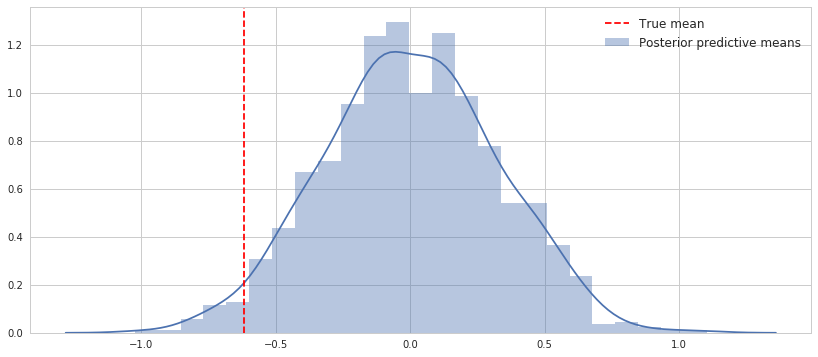

In [253]:
plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(new_y.mean(), color='r', ls='--', label='True mean')
ax.legend()

## About Model class

#### Reference to all random variables

In [135]:
model.basic_RVs

[mu, sd_log__, obs]

In [136]:
model.free_RVs

[mu, sd_log__]

In [137]:
model.obs

obs

In [138]:
model.observed_RVs

[obs]

In [139]:
model.logp({"mu" : 0, "sd_log__" : 1})

array(-23.390564071923375)

#### Access to probability distributions

In [254]:
list(filter(lambda x: x[0].isupper(), dir(pm.distributions)))

['AR',
 'AR1',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Bound',
 'Categorical',
 'Cauchy',
 'ChiSquared',
 'Constant',
 'ConstantDist',
 'Continuous',
 'DensityDist',
 'Dirichlet',
 'Discrete',
 'DiscreteUniform',
 'DiscreteWeibull',
 'Distribution',
 'ExGaussian',
 'Exponential',
 'Flat',
 'GARCH11',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'Interpolated',
 'InverseGamma',
 'LKJCholeskyCov',
 'LKJCorr',
 'Laplace',
 'Logistic',
 'Lognormal',
 'Mixture',
 'Multinomial',
 'MvGaussianRandomWalk',
 'MvNormal',
 'MvStudentT',
 'MvStudentTRandomWalk',
 'NegativeBinomial',
 'NoDistribution',
 'Normal',
 'NormalMixture',
 'Pareto',
 'Poisson',
 'SkewNormal',
 'StudentT',
 'TensorType',
 'Triangular',
 'Uniform',
 'VonMises',
 'Wald',
 'Weibull',
 'Wishart',
 'WishartBartlett',
 'ZeroInflatedBinomial',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedPoisson']

In [66]:
## use shape to create a list of random variables
## set initial values using testval

with pm.Model():
    x = pm.Normal("x", mu = 0, sd = 1, shape = 5, testval = np.random.randn(5))
    
x.tag.test_value    

array([-1.05031394, -1.35306727,  0.47758292,  0.63581962, -0.1301976 ])

In [74]:
# other sampling methods
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SGFS',
 'SMC',
 'Slice']

## Use other sampling algorithms

In [75]:
# use the step argument in pm.sample
with model:
    posterior_metropolis = pm.sample(draws = 1000, njobs = 4, tune = 500, step = pm.Metropolis())

100%|██████████| 1500/1500 [00:01<00:00, 1474.40it/s]


In [76]:
pm.summary(posterior_metropolis)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,-0.149238,0.098604,0.004086,-0.356643,0.025004,475.0,1.005567
sd,1.045248,0.073723,0.003103,0.912565,1.182823,465.0,1.002140


## Using Variation Inference (VI)

In [89]:
list(filter(lambda x: x[0].isupper(), dir(pm.variational.inference)))

['ADVI',
 'ASVGD',
 'Empirical',
 'FullRank',
 'FullRankADVI',
 'ImplicitGradient',
 'Inference',
 'KL',
 'KLqp',
 'KSD',
 'MeanField',
 'NFVI',
 'NormalizingFlow',
 'SVGD',
 'State']

In [141]:
with model:
    fit = pm.fit(method = "advi")

Average Loss = 12.574: 100%|██████████| 10000/10000 [00:06<00:00, 1440.46it/s]
Finished [100%]: Average Loss = 12.572


In [142]:
# the returned fit object is used to draw samples from the approximated posterior
trace = fit.sample(draws = 100000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb138f516a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fb138e1f588>], dtype=object)

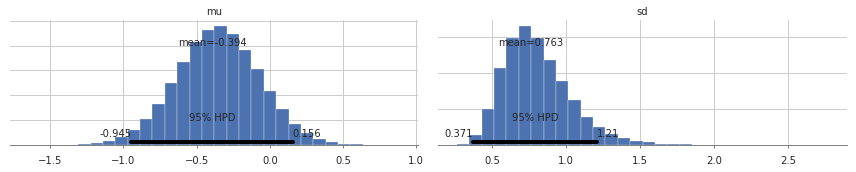

In [143]:
pm.plot_posterior(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb139c97ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb13bb72780>]], dtype=object)

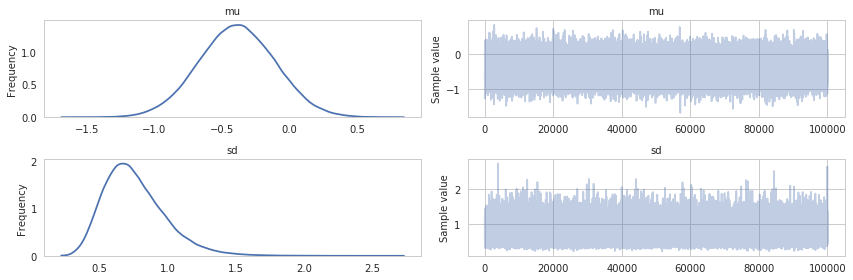

In [144]:
pm.traceplot(trace)

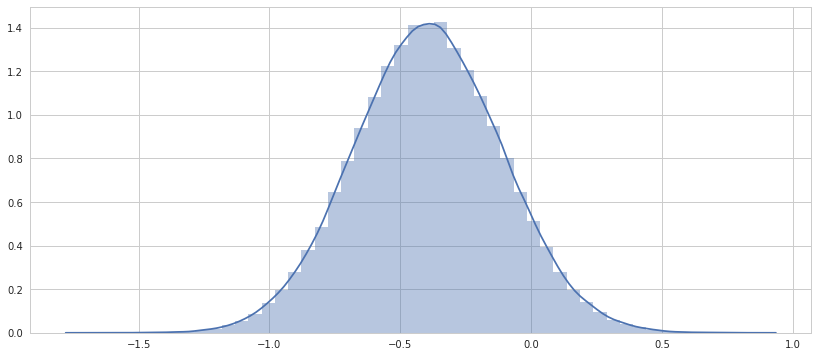

In [145]:
sns.distplot(trace["mu"])

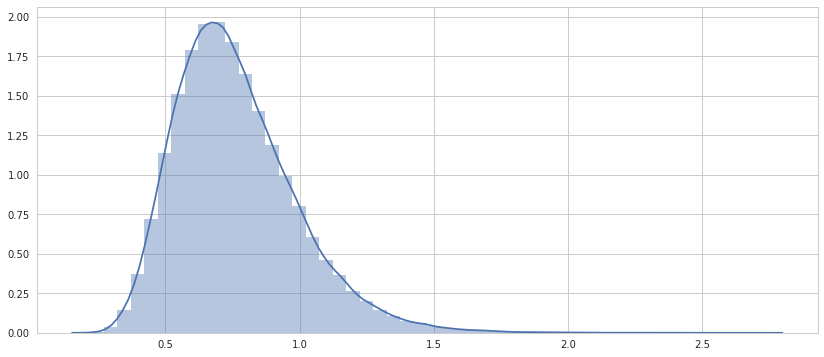

In [146]:
sns.distplot(trace["sd"])

In [147]:
trace["mu"]

array([-0.45217726, -0.71048452, -0.3392921 , ..., -0.28222226,
       -0.51566976, -1.14098097])

In [148]:
trace["sd"]

array([ 0.78161752,  0.59506474,  0.6043004 , ...,  0.48068611,
        0.70698899,  0.88231656])

## Eight Schools Example

In [190]:
# prepare the data
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

### Pooled model

In [191]:
# build the model

# start with a pooled model
with pm.Model() as schools_model_pooled:
    
    ## specify the priors
    mu = pm.Normal("mu", mu = 0, sd = 1e6)
       
    ## specify the likelihood
    obs = pm.Normal("obs", mu = mu, sd = sigma, observed = y)

In [192]:
# sample from the posterior
with schools_model_pooled:
    posterior_schools_pooled = pm.sample(draws = 1000, njobs = 4, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 1123.44it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb138ed64a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb13cb2ae10>]], dtype=object)

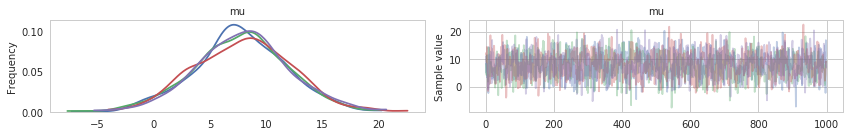

In [193]:
# Diagnoze convergence and MCMC chains
pm.traceplot(posterior_schools_pooled)

In [194]:
pm.gelman_rubin(posterior_schools_pooled)

{'mu': 1.0003430889657785}

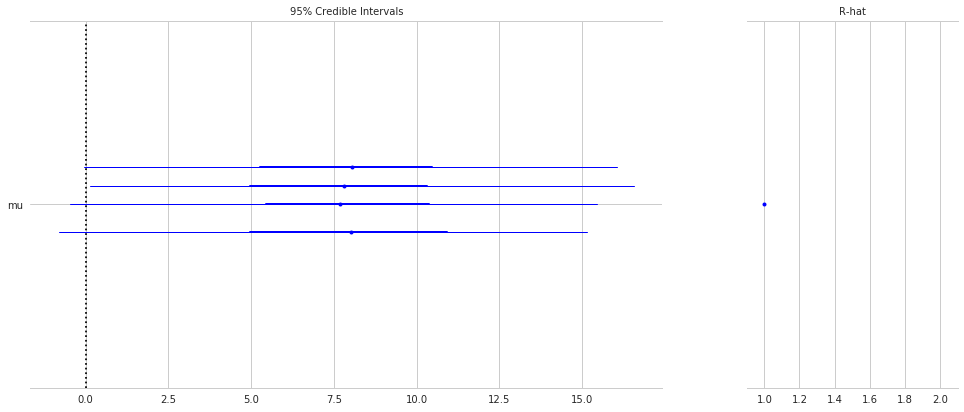

In [195]:
pm.forestplot(posterior_schools_pooled)

In [196]:
# give that converge is okay let's look at the parameter results
pm.summary(posterior_schools_pooled)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,7.789034,4.11841,0.097844,0.059062,16.345489,1767.0,1.000343


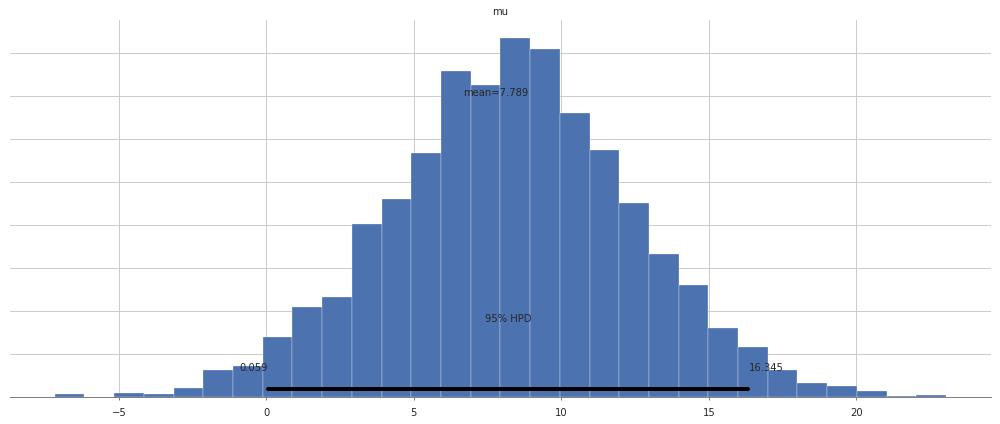

In [197]:
pm.plot_posterior(posterior_schools_pooled)

### Hierarchical model

In [198]:
# then build a hierachical model
with pm.Model() as schools_model:
    
    ## specify the priors
    eta = pm.Normal("eta", mu = 0, sd = 1, shape = J)
    mu = pm.Normal("mu", mu = 0, sd = 1e6)
    tau = pm.HalfCauchy("tau", beta = 1)
    
    theta = pm.Deterministic("theta", mu + tau*eta)
    
    ## specify the likelihood
    obs = pm.Normal("obs", mu = theta, sd = sigma, observed = y)

In [230]:
# sample from the posterior of hierarchical model
with schools_model:
    step = pm.NUTS(target_accept = 0.99) # increase step size from default 0.8 to 0.99
    posterior_schools = pm.sample(draws = 5000, njobs = 4, tune = 1000, step = step)

100%|██████████| 6000/6000 [00:26<00:00, 226.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb135a36390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb132119f28>]], dtype=object)

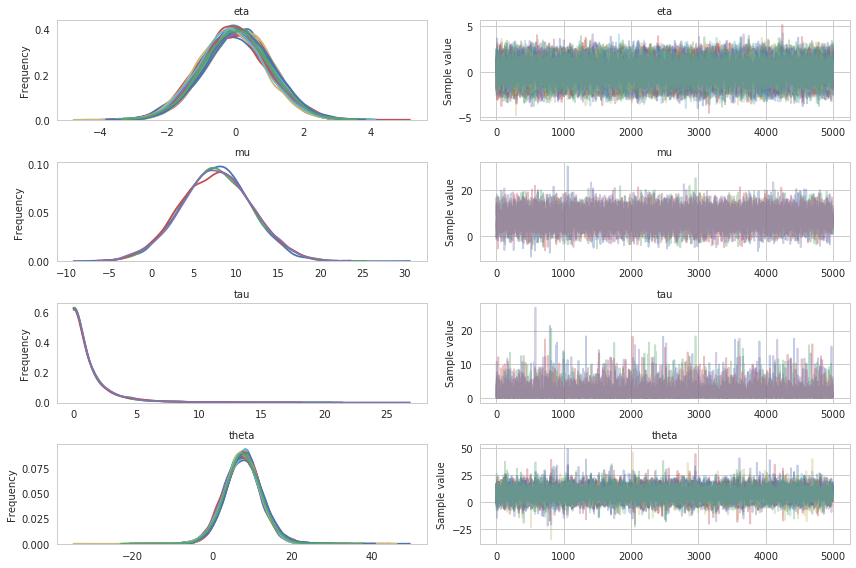

In [231]:
# diagonize covergence and MCMC chains
pm.traceplot(posterior_schools)

In [232]:
pm.gelman_rubin(posterior_schools)

{'eta': array([ 1.00003626,  1.00004374,  0.99996136,  0.99995295,  0.99996243,
         1.00000913,  1.00013728,  0.9999871 ]),
 'mu': 0.99994454315083214,
 'tau': 0.9999770348721726,
 'theta': array([ 0.9999115 ,  1.00001793,  1.00005699,  0.99995673,  0.99993312,
         0.99995423,  0.99992275,  0.99993888])}

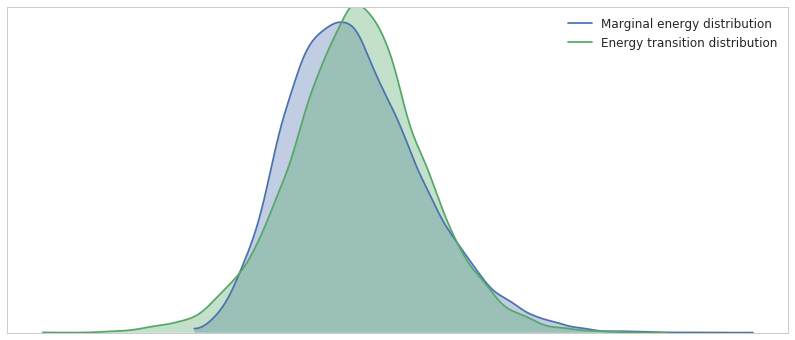

In [233]:
pm.energyplot(posterior_schools)

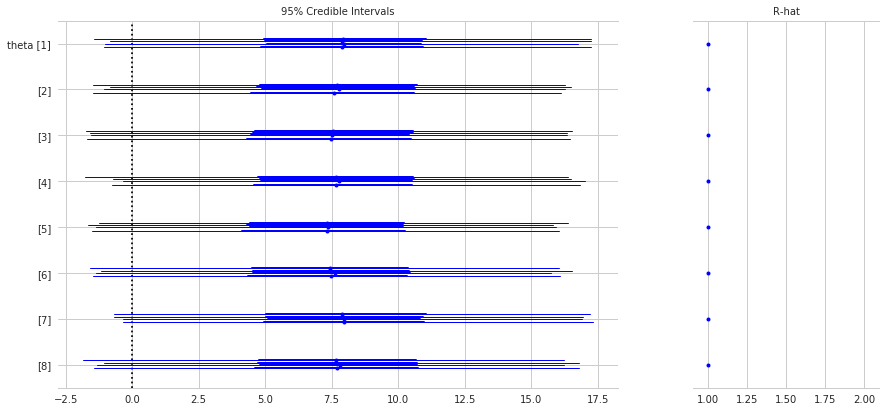

In [234]:
pm.forestplot(posterior_schools, varnames = ["theta"])

In [235]:
# looks that convergence went OK
# now critize the model
pm.summary(posterior_schools, varnames = ["theta", "mu", "tau"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,8.079975,4.738034,0.028453,-1.032482,17.238590,20000.0,0.999911
theta__1,7.682957,4.460921,0.022665,-1.284120,16.299801,20000.0,1.000018
theta__2,7.462252,4.669771,0.031173,-1.726986,16.381996,20000.0,1.000057
theta__3,7.651337,4.495683,0.025484,-0.758990,16.925815,20000.0,0.999957
theta__4,7.253464,4.478585,0.026569,-1.705488,15.853819,20000.0,0.999933
theta__5,7.427622,4.493788,0.027699,-1.465319,16.062224,20000.0,0.999954
theta__6,8.062226,4.528793,0.024933,-0.435356,17.256136,20000.0,0.999923
theta__7,7.733060,4.632008,0.028061,-1.374563,16.588769,20000.0,0.999939
mu,7.665344,4.175040,0.023394,-0.172619,16.224371,20000.0,0.999945
tau,1.476486,1.841439,0.011728,0.000316,4.955184,17811.0,0.999977


### Compare models

In [213]:
# lets use leave out one cross validation
pooled_loo = pm.loo(trace = posterior_schools, model = schools_model_pooled)

/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [214]:
pooled_loo.LOO

61.201757324230044

In [215]:
hierarchical_loo = pm.loo(trace = posterior_schools, model = schools_model)

/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [216]:
hierarchical_loo.LOO

61.127750071619822

In [220]:
compare_loo = pm.compare((posterior_schools, posterior_schools_pooled), 
                         (schools_model, schools_model_pooled), ic = "LOO")

In [221]:
compare_loo

,LOO,pLOO,dLOO,weight,SE,dSE,warning
0,61.13,0.76,0,1,2.15,0,1
1,61.33,0.77,0.2,0,2.22,0.13,1


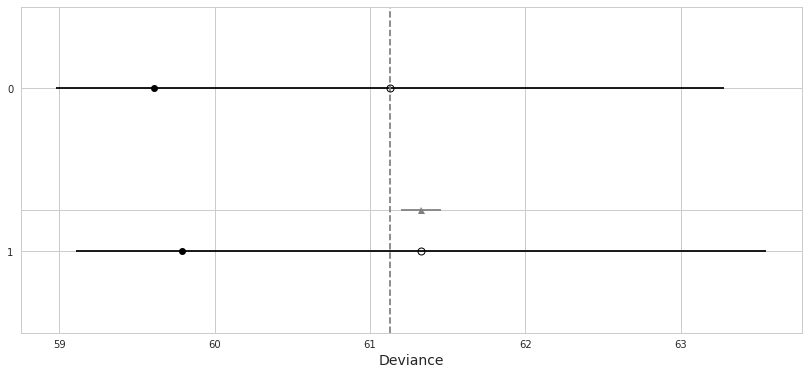

In [222]:
pm.compareplot(compare_loo)